In [1]:
from sstadex import Macromodel, Primitive, Test, dfs, simplediffpair, cs_pmos, cm_pmos, spice_sim, diffpair_cc, current_mirror_cc
import numpy as np
from sympy import Symbol
from sympy.solvers import solve
import matplotlib.pyplot as plt
import paretoset as pareto
import pandas as pd
from sympy import lambdify
from sstadex import Transistor
import seaborn as sns
sns.set_theme()
sns.color_palette("mako")

import importlib

In [2]:
## Exploration parameters

N_points = 10
lengths = [0.4e-06, 0.8e-06, 1.6e-06, 3.2e-06, 6.4e-6]

## Electrical parameters

Vout = 1.8                                      # LDO output voltage
Vin = 3.3                                       # LDO supply voltage
Vref = 1.35                                     # LDO voltage reference
IL = 100e-3                                     # Load current
CL = 1e-12                                      # Load capacitance
RL = Vout/IL

## LDO specifications

efficiency = 0.998
psrr_condition = -60
estability_condition = 80
linereg_condition = 0.5
loadreg_condition = 0.7
iq_condition = 20e-6
size_condition = 1e-3

I_bias = 40e-6
I_amp1 = 40e-6 # considering the two branches of differential pair
I_amp2 = 40e-6

Iq_max = IL*(1-efficiency)
Ib_pt = Iq_max-I_amp1-I_amp2-I_bias

R1 = (Vout-Vref)/Ib_pt
R2 = Vref*R1/(Vout-Vref)

LDO = pd.DataFrame.from_dict({'Vout': [Vout], 'Vin': [Vin], 'Vref': [Vref], 'IL': [IL], 'CL': [CL], 'RL': [RL], 'Iq_max': [Iq_max], 'Ib_pt': [Ib_pt], 'R1': [R1], 'R2': [R2]}, orient='index', columns=['Value'])
LDO

,Value
Vout,1.800000e+00
Vin,3.300000e+00
Vref,1.350000e+00
IL,1.000000e-01
CL,1.000000e-12
RL,1.800000e+01
Iq_max,2.000000e-04
Ib_pt,8.000000e-05
R1,5.625000e+03
R2,1.687500e+04


# Preparation

## Macromodels

In [30]:
LDO_macro = Macromodel(
    name ='LDO_macro', 
    outputs= [
        Symbol("W_pt"), Symbol("L_pt")],
    electrical_parameters={
        "Vdd": Vin, 
        "Vref": Vref, 
        "Vout": Vout, 
        "V2stage_out": 1.7,
        "Il": IL+Ib_pt}
    )

LDO_macro.area_conditions = {
    "max": [100e-3, 100e-3, 100e-3, 100e-3, 100e-3, 100e-3, 10, 100e-3, 100e-3, 100e-3, 100e-3, 100e-3, 100e-3],
    "min": [5e-6, 0, 5e-6, 0, 5e-6, 0, 0, 5e-6, 0, 5e-6, 0, 5e-6, 0]}

OTA_2stage_macro = Macromodel(
    name = 'OTA_2stage_macro',
    outputs = [
        Symbol("W_2stage"), Symbol("L_2stage"),
        Symbol('W_cs_2stage'), Symbol('L_cs_2stage')],
    electrical_parameters = {
        "Vdd": LDO_macro.electrical_parameters["Vdd"],
        "Vref": LDO_macro.electrical_parameters["Vref"],
        "Vout": LDO_macro.electrical_parameters["V2stage_out"],
        "V1stage_out": 1.6,
        "Il": I_amp2},
    macromodel_parameters={
        Symbol('Ra'): np.logspace(3, 7, N_points),
        Symbol('gma'): np.logspace(-5, -2, N_points),
        Symbol('Ca'): np.logspace(-17, -12, N_points)}
    )
OTA_2stage_macro.area_conditions = {
    "max": [100e-3, 100e-3, 100e-3, 100e-3, 100e-3, 100e-3, 10, 100e-3, 100e-3, 100e-3, 100e-3],
    "min": [5e-6, 0, 5e-6, 0, 5e-6, 0, 0, 5e-6, 0, 5e-6, 0]}

OTA_1stage_macro = Macromodel(
    name = 'OTA_1stage_macro',
    outputs = [
        Symbol("W_diff"), Symbol("L_diff"), 
        Symbol("W_al"), Symbol("L_al"),
        Symbol("W_cs"), Symbol("L_cs"),
        Symbol('vgs_cs')],
    electrical_parameters = {
        "Vdd": OTA_2stage_macro.electrical_parameters["Vdd"],
        "Vref": OTA_2stage_macro.electrical_parameters["Vref"],
        "Vout": OTA_2stage_macro.electrical_parameters["V1stage_out"],
        "Il": I_amp1},
    macromodel_parameters={Symbol('Ra_1stage'): np.logspace(3, 7, N_points),
                                              Symbol('gma_1stage'): np.logspace(-5, -2, N_points),
                                              Symbol('Ca_1stage'): np.logspace(-17, -12, N_points)}
    )

OTA_1stage_macro.area_conditions = {
    "max": [10e-3, 10e-3, 10e-3, 10e-3, 10e-3, 10e-3, 10],
    "min": [5e-6, 0, 5e-6, 0, 5e-6, 0, 0]}

## Primitives

In [4]:
pt = cs_pmos(
    netlist='pmos_cm.spice', 
    type='pmos', 
    inputs={
        'vds_lut': LDO_macro.electrical_parameters["Vout"]-LDO_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-2, -0.1, 0.01), 
        'vgs': LDO_macro.electrical_parameters["V2stage_out"]-LDO_macro.electrical_parameters["Vdd"], 
        'il': LDO_macro.electrical_parameters["Il"],
        'length': lengths, 
        '2d_var': ['length', 'vgs']})

pt.build()

pt.parameters = {
    Symbol('gm_pt'): np.asarray(pt.gm).flatten(),
    Symbol('Ro_pt'): np.asarray(pt.Ro).flatten(),
    Symbol("Cgg_pt"): np.asarray(pt.cgg).flatten(),
    Symbol("Cgd_pt"): np.asarray(pt.cgd).flatten(),
    Symbol("dropout"): 2/(np.asarray(pt.gm).flatten()/pt.inputs['il'])}

pt.outputs = {
    Symbol("W_pt"): np.asarray(pt.W).flatten(),
    Symbol("L_pt"): np.asarray(pt.L).flatten()}

##############################################################################

stage2_t = cs_pmos(
    netlist='pmos_cs.spice',
    type='pmos',
    inputs={
        'vds_lut': OTA_2stage_macro.electrical_parameters["Vout"]-OTA_2stage_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-2, -0.1, 0.01), 
        'vgs': OTA_2stage_macro.electrical_parameters["V1stage_out"]-LDO_macro.electrical_parameters["Vdd"], 
        'il': OTA_2stage_macro.electrical_parameters["Il"],
        'length': lengths, 
        '2d_var': ['length', 'vgs']})

stage2_t.build()

stage2_t.parameters = {
    Symbol('gm_2stage'): np.asarray(stage2_t.gm).flatten(),
    Symbol('Ro_2stage'): np.asarray(stage2_t.Ro).flatten(),
    Symbol('Cin_2stage'): np.asarray(stage2_t.cgg).flatten()+np.asarray(stage2_t.cgd).flatten()*(np.asarray(stage2_t.gm).flatten()*np.asarray(stage2_t.Ro).flatten()),
    Symbol("Cgg_2stage"): np.asarray(stage2_t.cgg).flatten(),
    Symbol("Cgd_2stage"): np.asarray(stage2_t.cgd).flatten()}

stage2_t.outputs = {
    Symbol("W_2stage"): np.asarray(stage2_t.W).flatten(),
    Symbol("L_2stage"): np.asarray(stage2_t.L).flatten()}

##############################################################################

vs = np.linspace(0.3, 1.5, 20)
vds_diffpar = OTA_1stage_macro.electrical_parameters["Vout"] - vs
vgs_diffpar = OTA_1stage_macro.electrical_parameters["Vref"] - vs

diffpair = simplediffpair(
    netlist='diffpair.spice',
    type='nmos',
    inputs = {
        'vds_lut': (0.1, 2, 0.01),
        'vgs_lut': (0.1, 2.2, 0.01), 
        'vds': vds_diffpar, 
        'vgs': vgs_diffpar, 
        'il': I_amp1/2,
        'length': lengths, 
        '2d_var': ['vds', 'vgs']}
)

diffpair.build()

diffpair.parameters = {
    Symbol('gdiff_1'): np.asarray(diffpair.gm).flatten(),
    Symbol('Rdiff_1'): np.asarray(diffpair.Ro).flatten(),
    Symbol("vs_diff"): np.tile(np.asarray(vs), len(lengths))}

diffpair.outputs = {
    Symbol("W_diff"): np.asarray(diffpair.W).flatten(),
    Symbol("L_diff"): np.asarray(diffpair.L).flatten()}

##############################################################################

activeload = cm_pmos(
    netlist='pmos_cs.spice',
    type='pmos',
    inputs={
        'vds_lut': OTA_1stage_macro.electrical_parameters["Vout"]-OTA_1stage_macro.electrical_parameters["Vdd"], 
        'vgs_lut': (-1.8, -0.1, 0.01), 
        'vgs': OTA_1stage_macro.electrical_parameters["Vout"]-OTA_1stage_macro.electrical_parameters["Vdd"], 
        'il': I_amp1/2,
        'length': lengths, 
        '2d_var': ['length', 'vgs']})

activeload.build()

activeload.parameters = {
    Symbol('gaload_1'): np.asarray(activeload.gm).flatten(),
    Symbol('Raload_1'): np.asarray(activeload.Ro).flatten()}

activeload.outputs = {
    Symbol("W_al"): np.asarray(activeload.W).flatten(),
    Symbol("L_al"): np.asarray(activeload.L).flatten()}

##############################################################################

currentsource = cm_pmos()
currentsource.parameters = {
    Symbol('gcs'): [],
    Symbol('Rcs'): [],
    Symbol('vs_cs'): [],
    Symbol('vgs_cs'): []}
currentsource.outputs = {
    Symbol("W_cs"): [],
    Symbol("L_cs"): []}


stage2_cs = cm_pmos()
stage2_cs.parameters = {
    Symbol('gcs_2stage'): [],
    Symbol('Rcs_2stage'): [],
    Symbol('vgs_cs_2stage'): []}
stage2_cs.outputs = {
    Symbol("W_cs_2stage"): [],
    Symbol("L_cs_2stage"): []}

for vds_cs in vs:

    vgs_cs = np.linspace(0.1, vds_cs+0.8, 5)

    currentsource_aux = cm_pmos(
        netlist='pmos_cs.spice',
        type='nmos',
        inputs={
            'vds_lut': vds_cs, 
            'vgs_lut': (0.1, 2, 0.01), 
            'vgs': vgs_cs, 
            'il': I_amp1,
            'length': lengths, 
            '2d_var': ['length', 'vgs']})
    currentsource_aux.build()

    currentsource.parameters[Symbol('gcs')].append(np.asarray(currentsource_aux.gm).flatten())
    currentsource.parameters[Symbol('Rcs')].append(np.asarray(currentsource_aux.Ro).flatten())
    currentsource.parameters[Symbol('vs_cs')].append(np.asarray(np.repeat(vds_cs, len(lengths)*len(vgs_cs))).flatten())
    currentsource.parameters[Symbol('vgs_cs')].append(np.asarray(np.tile(vgs_cs, len(lengths))).flatten())
    currentsource.outputs[Symbol('W_cs')].append(np.asarray(currentsource_aux.W).flatten())
    currentsource.outputs[Symbol('L_cs')].append(np.asarray(currentsource_aux.L).flatten())


    stage2_cs_aux = cm_pmos(
    netlist='pmos_cs.spice',
    type='nmos',
    inputs={
        'vds_lut': OTA_2stage_macro.electrical_parameters["Vout"],
        'vgs_lut': (0.1, 2, 0.01),
        'vgs': vgs_cs,
        'il': OTA_2stage_macro.electrical_parameters['Il'],
        'length': lengths,
        '2d_var': ['length', 'vgs']}
        )
    stage2_cs_aux.build()
    
    stage2_cs.parameters[Symbol('gcs_2stage')].append(np.asarray(stage2_cs_aux.gm).flatten())
    stage2_cs.parameters[Symbol('Rcs_2stage')].append(np.asarray(stage2_cs_aux.Ro).flatten())
    stage2_cs.parameters[Symbol('vgs_cs_2stage')].append(np.asarray(np.tile(vgs_cs, len(lengths))).flatten())
    stage2_cs.outputs[Symbol('W_cs_2stage')].append(np.asarray(currentsource_aux.W).flatten())
    stage2_cs.outputs[Symbol('L_cs_2stage')].append(np.asarray(currentsource_aux.L).flatten())


currentsource.parameters[Symbol('gcs')] = np.asarray(currentsource.parameters[Symbol('gcs')]).flatten()
currentsource.parameters[Symbol('Rcs')] = np.asarray(currentsource.parameters[Symbol('Rcs')]).flatten()
currentsource.parameters[Symbol('vs_cs')] = np.asarray(currentsource.parameters[Symbol('vs_cs')]).flatten()
currentsource.parameters[Symbol('vgs_cs')] = np.asarray(currentsource.parameters[Symbol('vgs_cs')]).flatten()
currentsource.outputs[Symbol('W_cs')] = np.asarray(currentsource.outputs[Symbol('W_cs')]).flatten()
currentsource.outputs[Symbol('L_cs')] = np.asarray(currentsource.outputs[Symbol('L_cs')]).flatten()
currentsource.outputs[Symbol('vgs_cs')] = currentsource.parameters[Symbol('vgs_cs')]

stage2_cs.parameters[Symbol('gcs_2stage')]=np.asarray(stage2_cs.parameters[Symbol('gcs_2stage')]).flatten()
stage2_cs.parameters[Symbol('Rcs_2stage')]=np.asarray(stage2_cs.parameters[Symbol('Rcs_2stage')]).flatten()
stage2_cs.parameters[Symbol('vgs_cs_2stage')]=np.asarray(stage2_cs.parameters[Symbol('vgs_cs_2stage')]).flatten()
stage2_cs.outputs[Symbol('W_cs_2stage')]=np.asarray(stage2_cs.outputs[Symbol('W_cs_2stage')]).flatten()
stage2_cs.outputs[Symbol('L_cs_2stage')]=np.asarray(stage2_cs.outputs[Symbol('L_cs_2stage')]).flatten()

##############################################################################



length
vgs
0
length
vgs
0
vds
vgs
1
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0
length
vgs
0


## Testbenches

### LDO

In [5]:
psrr_LDO_macro = Test()
psrr_LDO_macro.name = "psrr_LDO"
psrr_LDO_macro.tf = ["vout", "vdd"]
psrr_LDO_macro.netlist = "ldo"
psrr_LDO_macro.parametros = {Symbol("V1"): 1,
                             Symbol("V2"): 0,
                             Symbol("s"): 0,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2}

psrr_LDO_macro.opt_goal = "min"
psrr_LDO_macro.conditions = {"max": [3.162e-4]}
psrr_LDO_macro.variables = {}
psrr_LDO_macro.out_def = {"eval": psrr_LDO_macro.tf}

##############################################################################

dc_LDO_macro = Test()
dc_LDO_macro.name = "dc_LDO"
dc_LDO_macro.tf = ["vout", "vdd"]
dc_LDO_macro.netlist = "ldo"
dc_LDO_macro.parametros = {Symbol("V1"): 3.3,
                           Symbol("V2"): 1.35,
                           Symbol("s"): 0,
                           Symbol("Rl"): RL,
                           Symbol("Cl"): CL,
                           Symbol("R1"): R1, 
                           Symbol("R2"): R2}

dc_LDO_macro.opt_goal = "min"
dc_LDO_macro.conditions = {"min": [0]}
dc_LDO_macro.variables = {}
dc_LDO_macro.out_def = {"eval": dc_LDO_macro.tf}
x = Symbol("x")
dc_LDO_macro.lamd = lambdify(x, x*3.3)

##############################################################################

gain_ol_LDO_macro = Test()
gain_ol_LDO_macro.name = "gain_ol_LDO"
gain_ol_LDO_macro.tf = ["vout", "vol"]
gain_ol_LDO_macro.netlist = "ldo_ol"
gain_ol_LDO_macro.parametros = {Symbol("V1"): 0,
                             Symbol("V2"): 0,
                             Symbol("V3"): 1,
                             Symbol("s"): 0,
                             Symbol("C1"): 10,
                             Symbol("Cl"): CL,
                             Symbol("Rl"): RL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000}

gain_ol_LDO_macro.opt_goal = "min"
gain_ol_LDO_macro.conditions = {"min": [1]}
gain_ol_LDO_macro.variables = {}
gain_ol_LDO_macro.out_def = {"eval": gain_ol_LDO_macro.tf}

##############################################################################

phase_margin_LDO_macro = Test()
phase_margin_LDO_macro.name = "phase_margin_LDO"
phase_margin_LDO_macro.tf = ["vout", "vol"]
phase_margin_LDO_macro.netlist = "ldo_ol"
phase_margin_LDO_macro.parametros = {Symbol("V3"): 1,
                             Symbol("Rl"): RL,
                             Symbol("Cl"): CL,
                             Symbol("R1"): R1, 
                             Symbol("R2"): R2,
                             Symbol("R3"): 10000000000,
                             Symbol("C1"): 10}

phase_margin_LDO_macro.opt_goal = "min"
phase_margin_LDO_macro.conditions = {"min": [1]}
phase_margin_LDO_macro.variables = {}
phase_margin_LDO_macro.out_def = {"pm": phase_margin_LDO_macro.tf}

### OTA_1stage

In [18]:
gain_1stage_OTA = Test()
gain_1stage_OTA.tf = ("vout", "vpos")
gain_1stage_OTA.name = "gain_1stage"
gain_1stage_OTA.netlist = "ota_1stage"
gain_1stage_OTA.parametros = {
    Symbol("gdiff_2"): Symbol("gdiff_1"),
    Symbol("Rdiff_2"): Symbol("Rdiff_1"),
    Symbol("gaload_2"): Symbol("gaload_1"),
    Symbol("Raload_2"): Symbol("Raload_1"),
    Symbol("V1"): 0,
    Symbol("V_n"): 0,
    Symbol("V_p"): 1,
    Symbol("I2"): 0,
    Symbol("s"): 0}
gain_1stage_OTA.opt_goal = "max"
gain_1stage_OTA.conditions = {"min": [1]}
gain_1stage_OTA.variables = {}
gain_1stage_OTA.out_def = {"eval": gain_1stage_OTA.tf}

##################################################################

psrr_1stage_OTA = Test()
psrr_1stage_OTA.tf = ("vout", "vdd")
psrr_1stage_OTA.name = "psrr_1stage"
psrr_1stage_OTA.netlist = "ota_1stage"
psrr_1stage_OTA.parametros = {
    Symbol("gdiff_2"): Symbol("gdiff_1"),
    Symbol("Rdiff_2"): Symbol("Rdiff_1"),
    Symbol("gaload_2"): Symbol("gaload_1"),
    Symbol("Raload_2"): Symbol("Raload_1"),
    Symbol("V1"): 1,
    Symbol("V_n"): 0,
    Symbol("V_p"): 0,
    Symbol("I2"): 0,
    Symbol("s"): 0}
psrr_1stage_OTA.opt_goal = "max"
psrr_1stage_OTA.conditions = {"min": [0.0000001]}
psrr_1stage_OTA.variables = {}
psrr_1stage_OTA.out_def = {"eval": psrr_1stage_OTA.tf}

##################################################################

rout_1stage_OTA = Test()
rout_1stage_OTA.name = "rout_1stage"
rout_1stage_OTA.target_param = Symbol("Ra_1stage")
rout_1stage_OTA.tf = ["vout", "vr"]
rout_1stage_OTA.netlist = "ota_1stage_rout"
rout_1stage_OTA.parametros = {Symbol("gdiff_2"): Symbol("gdiff_1"),
                              Symbol("Rdiff_2"): Symbol("Rdiff_1"),
                                Symbol("gaload_2"): Symbol("gaload_1"),
                                Symbol("Raload_2"): Symbol("Raload_1"),
                                Symbol("V1"): 0,
                                Symbol("V_n"): 0,
                                Symbol("V_p"): 0,
                                Symbol("Vr"): 1,
                                Symbol("I2"): 0,
                                Symbol("s"): 0,
                                Symbol("Rr"): 1000,
                                Symbol("Cl"): 1e-12}

rout_1stage_OTA.opt_goal = "max"
rout_1stage_OTA.conditions = {"min": [2782.559402207126]}
x = Symbol("x")
rout_1stage_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_1stage_OTA.variables = {}
rout_1stage_OTA.out_def = {"eval": rout_1stage_OTA.tf}

##################################################################

gm_1stage_OTA = Test()
gm_1stage_OTA.target_param = Symbol("gma_1stage")
gm_1stage_OTA.name = "gm_1stage"
gm_1stage_OTA.tf = ["vout", "vpos"]
gm_1stage_OTA.netlist = "ota_1stage"
gm_1stage_OTA.composed = 1
gm_1stage_OTA.out_def = {"divide": [gain_1stage_OTA, rout_1stage_OTA]}
gm_1stage_OTA.opt_goal = "max"
gm_1stage_OTA.conditions = {"min": [9.999999999999999e-06]}

### OTA_2stage

In [7]:
gain_2stage_OTA = Test()
gain_2stage_OTA.name = "gain_2stage"
gain_2stage_OTA.tf = ["vout", "vpos"]
gain_2stage_OTA.netlist = "OTA_2stage"
gain_2stage_OTA.parametros = {
    Symbol("V1"): 0,
    Symbol("V2"): 1,
    Symbol("I_amp2"): 0,
    Symbol("s"): 0}

gain_2stage_OTA.opt_goal = "max"
gain_2stage_OTA.conditions = {"min": [3162]}
gain_2stage_OTA.variables = {}
gain_2stage_OTA.out_def = {"eval": gain_2stage_OTA.tf}

##############################################################################

rout_2stage_OTA = Test()
rout_2stage_OTA.name = "rout_2stage"
rout_2stage_OTA.target_param = Symbol("Ra")
rout_2stage_OTA.tf = ["vout", "vr"]
rout_2stage_OTA.netlist = "OTA_2stage_rout"
rout_2stage_OTA.parametros = {Symbol("gdiff_2"): Symbol("gdiff_1"),
                              Symbol("Rdiff_2"): Symbol("Rdiff_1"),
                                Symbol("gaload_2"): Symbol("gaload_1"),
                                Symbol("Raload_2"): Symbol("Raload_1"),
                                Symbol("V1"): 0,
                                Symbol("V2"): 0,
                                Symbol("Vr"): 1,
                                Symbol("I_amp2"): 0,
                                Symbol("s"): 0,
                                Symbol("Rr"): 1000}
rout_2stage_OTA.opt_goal = "max"
rout_2stage_OTA.conditions = {"min": [464158.8833612772]}
x = Symbol("x")
rout_2stage_OTA.lamd = lambdify(x, x*1000/(1-x))
rout_2stage_OTA.variables = {}
rout_2stage_OTA.out_def = {"eval": rout_2stage_OTA.tf}

##################################################################

gm_2stage_OTA = Test()
gm_2stage_OTA.target_param = Symbol("gma")
gm_2stage_OTA.name = "gm_2stage"
gm_2stage_OTA.tf = ["vout", "vpos"]
gm_2stage_OTA.netlist = "ota_2stage"
gm_2stage_OTA.composed = 1
gm_2stage_OTA.out_def = {"divide": [gain_2stage_OTA, rout_2stage_OTA]}
gm_2stage_OTA.opt_goal = "max"
gm_2stage_OTA.conditions = {"min": [0.00000001]}

##################################################################

bw_2stage_OTA = Test()
bw_2stage_OTA.tf = ("vout", "vpos")
bw_2stage_OTA.name = "bw_2stage"
bw_2stage_OTA.netlist = "ota_2stage"
bw_2stage_OTA.parametros = {Symbol("gaload_2"): Symbol("gaload"),
                                Symbol("Raload_2"): Symbol("Raload_1"),
                                Symbol("gdif_2"): Symbol("gdif_1"),
                                Symbol("Rdif_2"): Symbol("Rdif_1"),
                                Symbol("V1"): 0,
                                Symbol("V2"): 1,
                                Symbol("I_amp2"): 0}

bw_2stage_OTA.conditions = {"min": [1]}
bw_2stage_OTA.variables = {}
bw_2stage_OTA.out_def = {"frec": [bw_2stage_OTA.tf, -0.70794]}

##################################################################

gds_2stage_OTA = Test()
gds_2stage_OTA.name = "gds_2stage"
gds_2stage_OTA.tf = ["vout", "vpos"]
gds_2stage_OTA.netlist = "ota_2stage"
gds_2stage_OTA.composed = 1
gds_2stage_OTA.out_def = {"divide": [1, rout_2stage_OTA]}
gds_2stage_OTA.opt_goal = "max"
gds_2stage_OTA.conditions = {"min": [0.00000001]}

##################################################################

Ca_2stage_OTA = Test()
Ca_2stage_OTA.target_param = Symbol("Ca_2stage")
Ca_2stage_OTA.name = "cout_2stage"
Ca_2stage_OTA.tf = ["vout", "vpos"]
Ca_2stage_OTA.netlist = "ota_2stage"
Ca_2stage_OTA.composed = 1
Ca_2stage_OTA.out_def = {"divide": [gds_2stage_OTA, bw_2stage_OTA]}
Ca_2stage_OTA.opt_goal = "max"
Ca_2stage_OTA.conditions = {"min": [1e-20]}

# Build

In [ ]:
LDO_macro.primitives = [pt]
LDO_macro.submacromodels = [OTA_2stage_macro]
LDO_macro.num_level_exp = -1
LDO_macro.specifications = [psrr_LDO_macro]
LDO_macro.opt_specifications = [psrr_LDO_macro]
LDO_macro.is_primitive = 0
LDO_macro.run_pareto = False

OTA_2stage_macro.primitives = [stage2_t, stage2_cs]
OTA_2stage_macro.submacromodels = [OTA_1stage_macro]
OTA_2stage_macro.num_level_exp = -1
OTA_2stage_macro.specifications = [gain_2stage_OTA]
OTA_2stage_macro.opt_specifications = [gain_2stage_OTA]
OTA_2stage_macro.is_primitive = 0
OTA_2stage_macro.run_pareto = False

OTA_1stage_macro.primitives = [diffpair, activeload, currentsource]
OTA_1stage_macro.submacromodels = [] 
OTA_1stage_macro.num_level_exp = -1
OTA_1stage_macro.specifications = [gain_1stage_OTA, rout_1stage_OTA, gm_1stage_OTA]
OTA_1stage_macro.opt_specifications = [gain_1stage_OTA]
OTA_1stage_macro.is_primitive = 0

ldo_results, ldo_axes, ldo_primouts, ldo_df, _ = dfs(OTA_2stage_macro, debug = False)

############################################
Starting the exploration of:  OTA_2stage_macro
Netlist:  OTA_2stage
Running MNA... 
   vdd  vout  net1  vss  vpos
0    1     2     3    0     4
[['vout', 'vpos']]
in eval
#### creating the primods_list ####
mod:  <sstadex.models.macromodel.Macromodel object at 0x7f2bfc351960>
mod:  <sstadex.models.primitives.cs_pmos object at 0x7f2bfc9398d0>
mod:  <sstadex.models.primitives.cm_pmos object at 0x7f2bfc938d60>
primmods_outputs_aux:  {W_2stage: array([8.30550669e-07, 1.94305029e-06, 4.20791268e-06, 8.80749764e-06,
       1.80425334e-05]), L_2stage: array([4.0e-07, 8.0e-07, 1.6e-06, 3.2e-06, 6.4e-06]), W_cs_2stage: array([5.57685458e+01, 7.45351965e-02, 1.01750522e-04, 4.03388309e-06,
       1.13392457e-06, 6.40173747e+02, 5.71277225e-01, 4.83431955e-04,
       1.30427983e-05, 3.13284594e-06, 3.92307838e+02, 3.79137972e-01,
       4.67261977e-04, 2.19283185e-05, 5.79793406e-06, 3.90732546e+02,
       3.88665605e-01, 6.31916217e-04, 3.92670529e-05

In [32]:
ldo_df['gain'] = 20*np.log10(ldo_df['gain_2stage'])
ldo_df.sort_values(by='area')

,Ra_1stage,gma_1stage,Ca_1stage,gm_2stage,Ro_2stage,Cin_2stage,Cgg_2stage,Cgd_2stage,gcs_2stage,Rcs_2stage,...,L_al,W_cs,L_cs,vgs_cs,W_2stage,L_2stage,W_cs_2stage,L_cs_2stage,area,gain
12640,1.271931e+06,0.000120,3.593814e-17,0.000074,7.094037e+06,1.763442e-13,9.437336e-14,1.565391e-16,0.000244,3.860077e+05,...,0.000006,0.000006,8.000000e-07,0.944737,0.000009,0.000003,0.000006,8.000000e-07,0.000050,72.291354
4719,5.419579e+05,0.000154,3.593814e-17,0.000074,7.094037e+06,1.763442e-13,9.437336e-14,1.565391e-16,0.000121,2.769508e+06,...,0.000006,0.000005,3.200000e-06,1.289474,0.000009,0.000003,0.000005,3.200000e-06,0.000051,81.755182
25154,2.984058e+06,0.000088,1.000000e-12,0.000074,7.094037e+06,1.763442e-13,9.437336e-14,1.565391e-16,0.000166,1.108473e+06,...,0.000006,0.000006,1.600000e-06,1.100000,0.000009,0.000003,0.000006,1.600000e-06,0.000052,85.422517
4332,5.422398e+05,0.000154,2.782559e-13,0.000074,7.094037e+06,1.763442e-13,9.437336e-14,1.565391e-16,0.000206,9.332635e+05,...,0.000006,0.000009,1.600000e-06,0.992105,0.000009,0.000003,0.000009,1.600000e-06,0.000055,74.096373
5622,4.526150e+05,0.000190,2.782559e-13,0.000074,7.094037e+06,1.763442e-13,9.437336e-14,1.565391e-16,0.000187,1.011227e+06,...,0.000006,0.000007,1.600000e-06,1.039474,0.000009,0.000003,0.000007,1.600000e-06,0.000055,74.974612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117832,2.698075e+06,0.000527,5.994843e-15,0.000074,1.024259e+07,7.399252e-13,3.889270e-13,4.612546e-16,0.001071,7.527236e+05,...,0.000006,0.007161,3.200000e-06,0.492105,0.000018,0.000006,0.007161,3.200000e-06,0.021423,97.385082
56168,2.160150e+06,0.000434,1.668101e-15,0.000074,7.094037e+06,1.763442e-13,9.437336e-14,1.565391e-16,0.001128,2.991000e+05,...,0.000006,0.009994,1.600000e-06,0.476316,0.000009,0.000003,0.009994,1.600000e-06,0.021532,85.967743
115595,2.160150e+06,0.000434,1.668101e-15,0.000074,1.024259e+07,7.399252e-13,3.889270e-13,4.612546e-16,0.001128,2.991000e+05,...,0.000006,0.009994,1.600000e-06,0.476316,0.000018,0.000006,0.009994,1.600000e-06,0.021545,86.132659
57565,2.697986e+06,0.000527,3.593814e-17,0.000074,7.094037e+06,1.763442e-13,9.437336e-14,1.565391e-16,0.001159,1.079473e+05,...,0.000006,0.008099,8.000000e-07,0.492105,0.000009,0.000003,0.008099,8.000000e-07,0.023283,80.945207


/tmp/ipykernel_37917/2359622815.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=ldo_df, x='area', y='gain', palette='viridis')


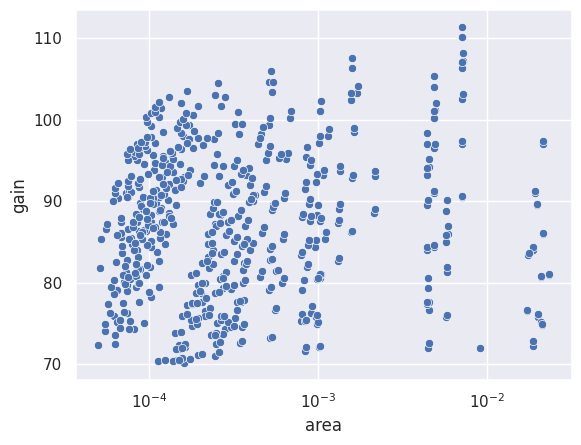

In [33]:
sns.scatterplot(data=ldo_df, x='area', y='gain', palette='viridis')
plt.xscale('log')

In [11]:
W_diff = ldo_df[Symbol("W_diff")].values*1e6
L_diff = ldo_df[Symbol("L_diff")].values*1e6

W_al = ldo_df[Symbol("W_al")].values*1e6
L_al = ldo_df[Symbol("L_al")].values*1e6

W_cs = ldo_df[Symbol("W_cs")].values*1e6
L_cs = ldo_df[Symbol("L_cs")].values*1e6

W_2stage = ldo_df[Symbol('W_2stage')].values*1e6
L_2stage = ldo_df[Symbol('L_2stage')].values*1e6

W_cs_2stage = ldo_df[Symbol('W_cs_2stage')].values*1e6
L_cs_2stage = ldo_df[Symbol('L_cs_2stage')].values*1e6

W_pt = ldo_df[Symbol('W_pt')].values*1e6
L_pt = ldo_df[Symbol('L_pt')].values*1e6

mult_diff = []
for idx, i in enumerate(W_diff):
    if i>100:
        mult_diff.append(10)
    else:
        mult_diff.append(1)

mult_al = []
for idx, i in enumerate(W_al):
    if i>100:
        mult_al.append(10)
    else:
        mult_al.append(1)

values = {
    "XM1": [
        W_diff,
        L_diff,
        mult_diff,
        "nfet",
    ],
    "XM2": [
        W_diff,
        L_diff,
        mult_diff,
        "nfet",
    ],
    "XM3": [
        W_al,
        L_al,
        mult_diff,
        "nfet",
    ],
    "XM4": [
        W_al,
        L_al,
        mult_diff,
        "nfet",
    ],
    "XM5": [
        W_2stage,
        L_2stage,
        mult_diff,
        "nfet",
    ],
    "XM6": [
        W_cs,
        L_cs,
        mult_diff,
        "nfet",
    ],
    "XM7": [
        W_cs,
        L_cs,
        mult_diff,
        "nfet",
    ],
    "XM8": [
        W_cs_2stage,
        L_cs_2stage,
        mult_diff,
        "nfet",
    ],
    "XM9": [
        W_pt,
        L_pt,
        mult_diff,
        "nfet",
    ],
    "I2": np.full(len(W_diff), I_amp1)
}

simulation_results = spice_sim("ldo_tb", values)

KeyError: W_diff

In [ ]:
gain_error = []

for df in simulation_results:
    gain_error.append(float(df.columns[1]))

ldo_df["gain_sim"]=gain_error
ldo_df["gain_error"] = (np.abs(np.asarray(gain_error) - ldo_df["gain"].values)/np.asarray(gain_error))*100

ldo_df.sort_values(by='area')

In [ ]:
x = Symbol('x')
y = Symbol('y')
z = Symbol('z')
t = Symbol('t')

test = lambdify([x, y, z], (x+y+z+t)/t, 'numpy')

In [ ]:
a = np.asarray([[1,2], [3,4]])
b = np.asarray([3,5])

In [ ]:
mesh = np.meshgrid([0,1], [0,1])
mesh

(array([[0, 1],
        [0, 1]]),
 array([[0, 0],
        [1, 1]]))

In [ ]:
a = a[:, tuple(mesh[0].flatten()),]
b = b[tuple(mesh[1].flatten()),]

In [ ]:
import time

In [ ]:
start_time = time.time()
test(1, 2, 3)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0003383159637451172 seconds ---


In [ ]:
exp = x+y+z+t

In [ ]:
start_time = time.time()
exp.subs({x: np.asarray([1,2]), y: np.asarray([3,4]), z: np.asarray([3,4])})
print("--- %s seconds ---" % (time.time() - start_time))

SympifyError: SympifyError: array([1, 2])

In [ ]:
a = {'a': [1, 2], 'b': [3, 4]}
df = pd.DataFrame.from_dict(a)

In [ ]:
dict(df.iloc[0])

{'a': np.int64(1), 'b': np.int64(3)}

In [ ]:
len(df)

2